In [11]:
image_path = "/content/test-diffusers/images/mapa_REALISTIC.png"

In [12]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

def crop_image(original_image: Image.Image, target_size: tuple) -> Image.Image:
    """
    Crop the image to the target size while preserving the aspect ratio.
    Extra parts are cropped using a center-crop strategy.

    Parameters:
        original_image (PIL.Image.Image): The input image.
        target_size (tuple): The desired output size (width, height).

    Returns:
        PIL.Image.Image: The cropped image.
    """
    return ImageOps.fit(original_image, target_size, method=Image.BICUBIC)

def process_canny_map(cropped_image: Image.Image) -> Image.Image:
    """
    Process the cropped image to produce a Canny edge map.
    This map highlights strong edges, preserving roads, building outlines, and open area boundaries.

    Parameters:
        cropped_image (PIL.Image.Image): The pre-cropped input image.

    Returns:
        PIL.Image.Image: The processed Canny edge map.
    """
    # Convert image to grayscale
    image_gray = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_RGB2GRAY)
    # Apply Canny edge detection (thresholds can be adjusted)
    edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)
    return Image.fromarray(edges)

def process_depth_map(cropped_image: Image.Image) -> Image.Image:
    """
    Process the cropped image to produce a simulated depth map.
    This example creates a placeholder depth map by converting the image to grayscale
    and applying a Gaussian blur.

    Parameters:
        cropped_image (PIL.Image.Image): The pre-cropped input image.

    Returns:
        PIL.Image.Image: The simulated depth map.
    """
    # Convert image to grayscale to simulate depth information
    image_gray = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur to mimic smooth transitions of depth (placeholder)
    depth = cv2.GaussianBlur(image_gray, (7, 7), sigmaX=0)
    return Image.fromarray(depth)

In [13]:
original_image = Image.open(image_path).convert("RGB")
target_size = (512, 512)  # Desired dimensions for processing

# Crop the image to the target size
cropped_image = crop_image(original_image, target_size)

# Generate control maps from the cropped image
canny_map = process_canny_map(cropped_image)
depth_map = process_depth_map(cropped_image)

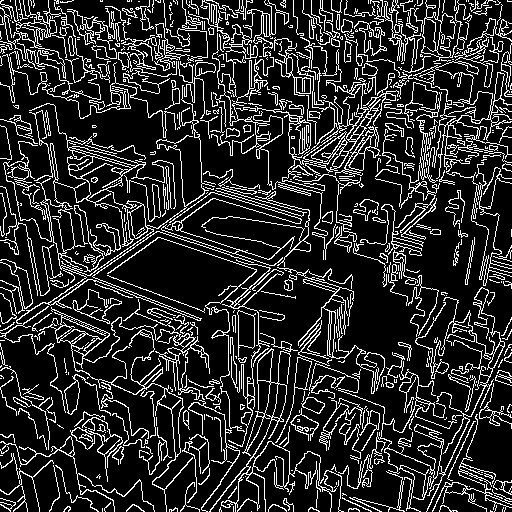

In [16]:
canny_map

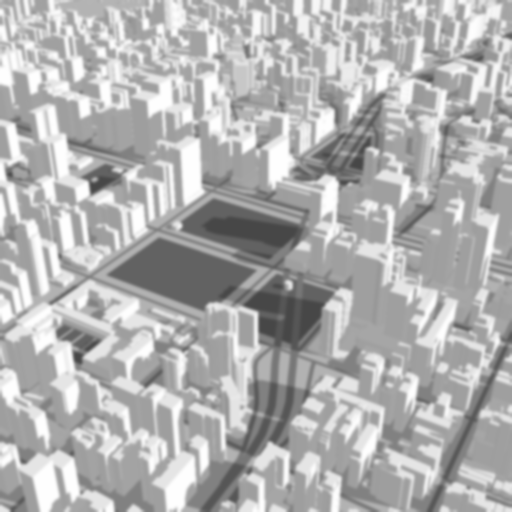

In [17]:
depth_map

In [31]:
from PIL import Image
from controlnet_aux import CannyDetector, MidasDetector

def process_canny_edges(original_image):
    """Process Canny edge detection"""
    return CannyDetector()(original_image)

def process_depth_map(original_image):
    """Process depth map with proper initialization"""
    midas = MidasDetector.from_pretrained("lllyasviel/Annotators")
    return midas(original_image)

def prepare_input(image, target_size, fit_to='height'):
    """
    Aspect-preserving resize with center crop
    Args:
        image: PIL.Image - Input image to process
        target_size: tuple - (width, height) of output
        fit_to: str - 'height' or 'width' to prioritize dimension
    Returns:
        PIL.Image: Processed image
    """
    image = Image.open(image_path)
    original_width, original_height = image.size
    target_width, target_height = target_size

    # Calculate scaling based on chosen dimension
    if fit_to == 'height':
        scale = target_height / original_height
    else:  # width
        scale = target_width / original_width

    # Calculate new dimensions
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize first
    resized = image.resize((new_width, new_height), Image.LANCZOS)

    # Calculate crop coordinates
    if fit_to == 'height':
        left = (new_width - target_width) // 2
        top = 0
        right = left + target_width
        bottom = target_height
    else:
        left = 0
        top = (new_height - target_height) // 2
        right = target_width
        bottom = top + target_height

    return resized.crop((left, top, right, bottom))

In [35]:
# Usage flow:
# TESTAR COM UMA IMAGEM COM VARIOS PREDIOS COLORIDOS E VER A PERFORMANCE DO DEPTH E CANNY
target_size = (512, 512)
image_path = "/content/test-diffusers/images/mapa_DEPTH.png"
prepared_image = prepare_input(image_path, target_size)
canny_map = process_canny_edges(prepared_image)
depth_map = process_depth_map(prepared_image)

/usr/local/lib/python3.11/dist-packages/controlnet_aux/midas/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location

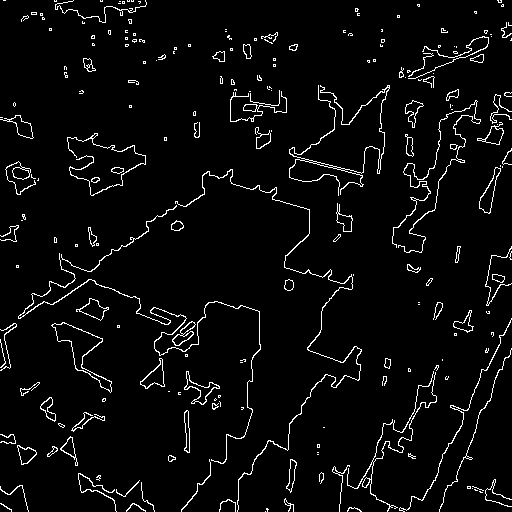

In [36]:
canny_map

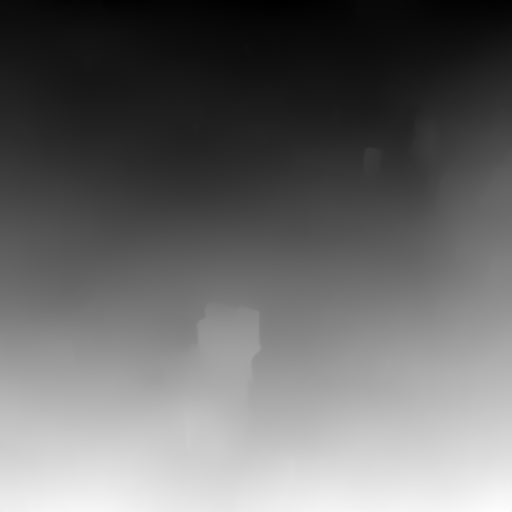

In [37]:
depth_map

#### Setup inicial

In [1]:
!git clone https://github.com/LRaupp/test-diffusers.git

Cloning into 'test-diffusers'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 79 (delta 38), reused 55 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 6.53 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
import os
from huggingface_hub import login

wkdir = "/content/test-diffusers"
os.chdir(wkdir)

safetensors_dir = os.path.join(wkdir, "safetensors/")

image_ade20k = f"{wkdir}/images/mapa_ADE20K_FIX.png"
image_depth = f"{wkdir}/images/mapa_DEPTH_FIX.png"
image_real = f"{wkdir}/images/mapa_REALISTIC.png"
image_edge = f"{wkdir}/images/mapa_EDGE.png"

In [ ]:
login()

In [ ]:
## Local
# !pip install --upgrade -r "./requirements.txt"

## Colab
#!pip install -U xformers --index-url https://download.pytorch.org/whl/cu124

In [ ]:
import models as M
import torch
from utils import preprocess_image

#### Prompt base

In [ ]:
prompt = """Ultra-realistic aerial view of a modern city, captured from a high-resolution satellite or drone. Buildings, residential areas, roads, and parks are detailed and proportional, with natural lighting and depth. Clear atmosphere with soft haze near the horizon."""
negative_prompt = "Distorted buildings, warped roads, AI artifacts, unnatural lighting, low detail, fisheye effect."
num_images = 1

prompts = [prompt]* num_images
negative_prompts = [negative_prompt]* num_images

In [ ]:
tensor_size = (768, 576)
segment_tensor = preprocess_image(image_ade20k, tensor_size)
depth_tensor = preprocess_image(image_depth, tensor_size)
tile_tensor = preprocess_image(image_real, tensor_size)
canny_tensor = preprocess_image(image_edge, tensor_size)

## BaseModel

#### SD1_5Model

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### SDXL1

In [ ]:
diffuser = diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SDXL1,
    controlnet_images=(
        (0, M.ControlModes.openpose),
        (depth_tensor, M.ControlModes.depth),
        (0, M.ControlModes.hed),
        (canny_tensor, M.ControlModes.canny),
        (0, M.ControlModes.normal),
        (segment_tensor, M.ControlModes.segment),
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    control_image=diffuser.valid_control_ref_images,
    control_mode=diffuser.valid_control_modes_index,
    num_inference_steps=50,
    guidance_scale=5,
)

In [ ]:
output.images[0]

#### SDXL1 Refiner

In [ ]:
diffuser = diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SDXL1Refiner,
    controlnet_images=(
        (0, M.ControlModes.openpose),
        (depth_tensor, M.ControlModes.depth),
        (0, M.ControlModes.hed),
        (canny_tensor, M.ControlModes.canny),
        (0, M.ControlModes.normal),
        (segment_tensor, M.ControlModes.segment),
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    union_control=True,
    union_control_type=torch.Tensor([0, 1, 0, 1, 0, 1]),
    weight=1
)

In [ ]:
output.images[0]

#### FluxV1_Dev

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.FluxV1_Dev,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### RealisticVisionV2

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.RealisticVisionV2,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### RealisticVisionV3

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.RealisticVisionV3,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### RealisticVisionV4

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.RealisticVisionV4,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### RealisticVisionV5

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.RealisticVisionV5,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### RealisticVisionV6

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.RealisticVisionV6,
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

## LoRa

#### LoRa (ABirdsEyeViewOfArchitectureV1) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.ABirdsEyeViewOfArchitectureV1(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### LoRa (ABirdsEyeViewOfArchitectureV3) + ControlNet

#### LoRa (AARGAerial) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.AARGAerial(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    controlnet_conditioning_scale=[1.0, 0.9, 1.0],
    weight=1
)

In [ ]:
output.images[0]

#### LoRa (AerialViewV2) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.AerialViewV2(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    controlnet_conditioning_scale=[1.0, 0.9, 1.0],
    weight=1
)

In [ ]:
output.images[0]

#### LoRa (FluxDStyleUrbanJungles) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.FluxV1_Dev,
    lora_model=M.FluxDStyleUrbanJungles(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=6,
    controlnet_conditioning_scale=[1.0, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### LoRa (JZCGXL026) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    lora_model=M.JZCGXL026(base_local_path=safetensors_dir),
    controlnet_images=(
        (0, M.ControlModes.openpose),
        (depth_tensor, M.ControlModes.depth),
        (0, M.ControlModes.hed),
        (canny_tensor, M.ControlModes.canny),
        (0, M.ControlModes.normal),
        (segment_tensor, M.ControlModes.segment),
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    union_control=True,
    union_control_type=torch.Tensor([0, 1, 0, 1, 0, 1]),
    weight=1
)

In [ ]:
output.images[0]

#### LoRa (JZCG005RealisticCityPhotography) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.JZCG005RealisticCityPhotography(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline


In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    controlnet_conditioning_scale=[1.0, 0.9, 1.0],
    weight=1
)

In [ ]:
output.images[0]

#### LoRa (UrbanRealisticCityBirdsEyeView) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.UrbanRealisticCityBirdsEyeView(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline


In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=5,
    controlnet_conditioning_scale=[1.0, 0.9, 1.0],
)

In [ ]:
output.images[0]

#### LoRa (BirdsEyeViewUrbanDesignScenes) + ControlNet

In [ ]:
diffuser = M.PlaceDiffusionModel(
    base_diffusion_model=M.SD1_5Model,
    lora_model=M.BirdsEyeViewUrbanDesignScenes(base_local_path=safetensors_dir),
    controlnet_images=(
        (segment_tensor, M.ControlModes.segment),
        (depth_tensor, M.ControlModes.depth),
        (canny_tensor, M.ControlModes.canny)
    )
)

In [ ]:
pipe = diffuser.pipeline

In [ ]:
output = pipe(
    prompt=prompts,
    negative_prompt=negative_prompts,
    image=diffuser.control_ref_images,
    num_inference_steps=50,
    guidance_scale=6,
    controlnet_conditioning_scale=[0.7, 0.9, 1.0],
)

In [ ]:
output.images[0]